In [20]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import wfdb
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

In [21]:
# enable numpy behavior
np_config.enable_numpy_behavior()

In [22]:
data_path = 'mitbih-af/'

In [23]:
# Get the list of all record files in the folder
# List of Patients
data = ['04015','04043','04048','04126','04746','04908','04936','05091',
           '05121','05261','06426','06453','06995','07162','07859','07879',
           '07910','08215','08219','08378','08405','08434','08455']

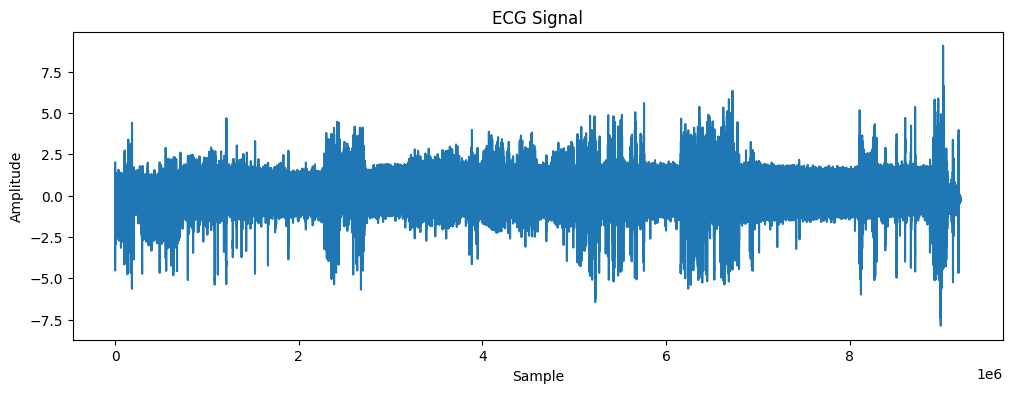

In [24]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in data:
    # Generating filepath for all .atr file names
    file = data_path + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'data Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

# Loop over all records and load the signal and annotations
for record_name in data:
    record_path = os.path.join(data_path, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:,0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Get the signal and labels
    sig = ecg_signal
    labels = np.array(annotation.symbol)

plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal')
plt.show()

In [25]:
import numpy as np

# Menghitung kekuatan sinyal (Signal Power)
signal_power = np.var(sig)  # sig adalah sinyal asli

# Menghitung kekuatan noise (Noise Power)
# Untuk data EKG, noise seringkali dianggap sebagai seluruh sinyal karena noise dalam data EKG bervariasi
# Anda dapat menggunakan seluruh sinyal sebagai noise
noise_power = np.var(sig)

# Menghitung SNR
snr = 10 * np.log10(signal_power / noise_power)

print("SNR:", snr)


SNR: 0.0


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate, signal
from scipy.signal import resample, butter, filtfilt, find_peaks
import pywt
from scipy import integrate
import cv2

# Normalize the data
sig = (sig - np.mean(sig)) / np.std(sig)

# Resample the data to new_sampling_rate
new_sampling_rate = 250
record = {"fs": 1000}  # Define the sampling rate
sig_resampled = resample(sig, int(len(sig) * (new_sampling_rate / record["fs"])))

# Bandpass filter the data
lowcut = 5.0
highcut = 15.0
sampling_rate = new_sampling_rate

def bandpass_filter(data, lowcut, highcut, sampling_rate, order=4):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


sig_filtered = bandpass_filter(sig_resampled, lowcut, highcut, sampling_rate, order=4)

def wavelet_denoising(data):
    waveletname = 'db6'
    threshold = 0.04
    level = pywt.dwt_max_level(len(data), waveletname)
    coeff = pywt.wavedec(data, waveletname, level=level)
    sigma = threshold*np.median(np.abs(coeff[-level]))
    uthresh = sigma*np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname)
    return reconstructed_signal

sig_denoised = wavelet_denoising(sig_filtered)

# Define structuring element for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Dilate the signal
sig_dilated = cv2.dilate(sig_filtered, kernel)

# Erode the signal
sig_eroded = cv2.erode(sig_filtered, kernel)

# Perform opening operation on the signal
sig_opened = cv2.morphologyEx(sig_filtered, cv2.MORPH_OPEN, kernel)

# Extract morphological features
def extract_morphological_features(signal):
    features = {}
    
    # Calculate mean of the signal
    features['mean'] = np.mean(signal)
    
    # Calculate standard deviation of the signal
    features['std'] = np.std(signal)
    
    # Calculate maximum value of the signal
    features['max'] = np.max(signal)
    
    # Calculate minimum value of the signal
    features['min'] = np.min(signal)
    
    # Calculate median value of the signal
    features['median'] = np.median(signal)
    
    # Calculate skewness of the signal
    features['skew'] = scipy.stats.skew(signal)
    
    # Calculate kurtosis of the signal
    features['kurtosis'] = scipy.stats.kurtosis(signal)
    
    return features

# Calculate morphological features from the signals
morphological_features_filtered = extract_morphological_features(sig_filtered)
morphological_features_dilated = extract_morphological_features(sig_dilated)
morphological_features_eroded = extract_morphological_features(sig_eroded)
morphological_features_opened = extract_morphological_features(sig_opened)

In [27]:
sign = sig_filtered, sig_denoised, sig_dilated, sig_eroded, sig_opened

In [28]:
# Inisialisasi KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
# Fungsi untuk menghitung Signal-to-Noise Ratio (SNR)
def calculate_snr(clean_data, denoised_data):
    noise = clean_data - denoised_data
    signal_power = tf.reduce_mean(tf.square(clean_data))
    noise_power = tf.reduce_mean(tf.square(noise))
    snr = 10 * tf.math.log(signal_power / noise_power) / tf.math.log(10.0)
    return snr

In [30]:
# Membangun model Deep CNN Autoencoder
def build_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    # Encoder
    x = Conv1D(16, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    # Decoder
    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(16, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    outputs = Conv1D(1, 3, activation='linear', padding='same')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [31]:
sign_array = np.array(sign[3])
sign = np.squeeze(sign_array)  # Reshape the array to remove the singleton dimension

Dimensi data pelatihan: (1841152, 1, 1)
Dimensi data pengujian: (460288, 1, 1)
Epoch 1/100
3596/3596 [==============================] - 30s 8ms/step - loss: 9.6029e-04 - root_mean_squared_error: 0.0310 - val_loss: 4.6854e-06 - val_root_mean_squared_error: 0.0022
Epoch 2/100
3596/3596 [==============================] - 31s 9ms/step - loss: 2.6812e-06 - root_mean_squared_error: 0.0016 - val_loss: 1.4072e-06 - val_root_mean_squared_error: 0.0012
Epoch 3/100
3596/3596 [==============================] - 31s 9ms/step - loss: 2.0877e-06 - root_mean_squared_error: 0.0014 - val_loss: 2.7764e-08 - val_root_mean_squared_error: 1.6662e-04
Epoch 4/100
3596/3596 [==============================] - 31s 9ms/step - loss: 1.3970e-06 - root_mean_squared_error: 0.0012 - val_loss: 1.6076e-08 - val_root_mean_squared_error: 1.2679e-04
Epoch 5/100
3596/3596 [==============================] - 31s 9ms/step - loss: 1.6361e-06 - root_mean_squared_error: 0.0013 - val_loss: 3.8664e-07 - val_root_mean_squared_error: 

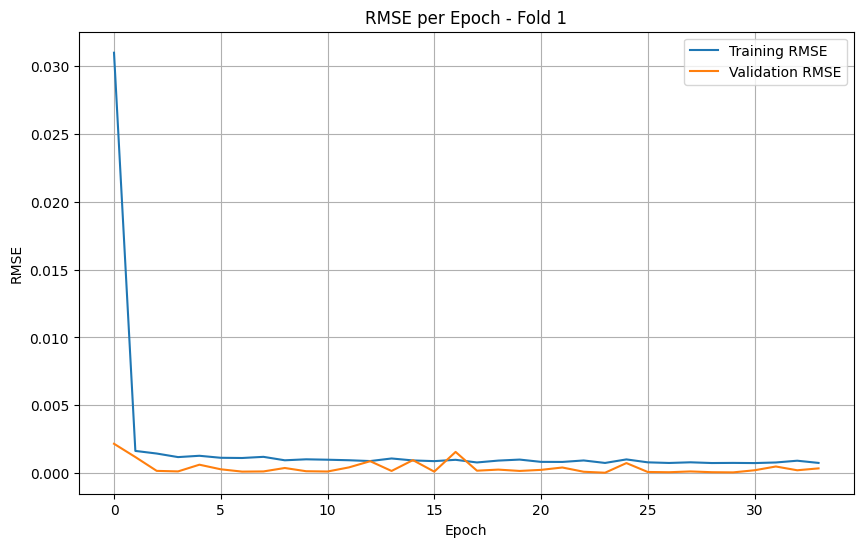

14384/14384 [==============================] - 35s 2ms/step - loss: 9.1550e-10 - root_mean_squared_error: 3.0257e-05
Signal to Noise Ratio (SNR) fold-1: tf.Tensor(77.73770774230177, shape=(), dtype=float64)
Root Mean Squared Error (RMSE) fold-1: 3.025729165528901e-05
Dimensi data pelatihan: (1841152, 1, 1)
Dimensi data pengujian: (460288, 1, 1)
Epoch 1/100
3596/3596 [==============================] - 37s 9ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 4.5594e-07 - val_root_mean_squared_error: 6.7523e-04
Epoch 2/100
3596/3596 [==============================] - 32s 9ms/step - loss: 2.3198e-06 - root_mean_squared_error: 0.0015 - val_loss: 2.3916e-06 - val_root_mean_squared_error: 0.0015
Epoch 3/100
3596/3596 [==============================] - 32s 9ms/step - loss: 2.4758e-06 - root_mean_squared_error: 0.0016 - val_loss: 1.6031e-07 - val_root_mean_squared_error: 4.0039e-04
Epoch 4/100
3596/3596 [==============================] - 32s 9ms/step - loss: 2.1839e-06 - root_m

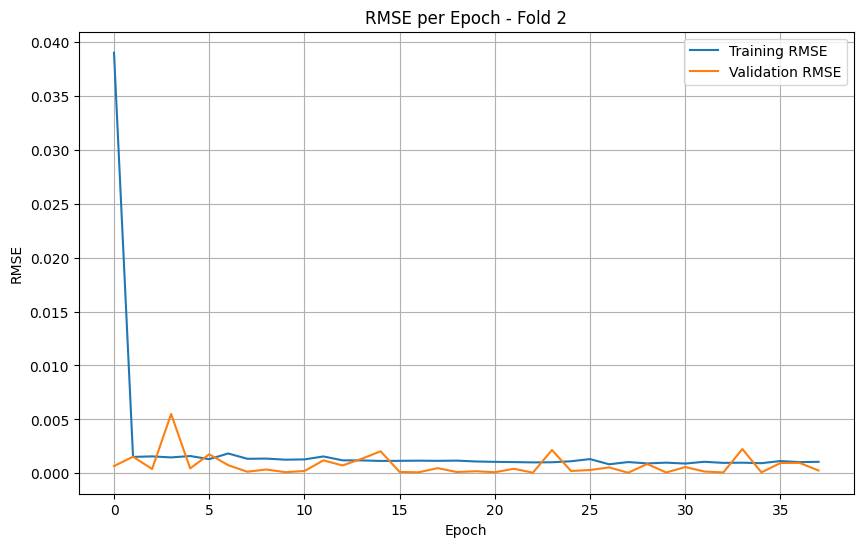

14384/14384 [==============================] - 35s 2ms/step - loss: 3.4506e-09 - root_mean_squared_error: 5.8742e-05
Signal to Noise Ratio (SNR) fold-2: tf.Tensor(72.05165992855859, shape=(), dtype=float64)
Root Mean Squared Error (RMSE) fold-2: 5.8741999964695424e-05
Dimensi data pelatihan: (1841152, 1, 1)
Dimensi data pengujian: (460288, 1, 1)
Epoch 1/100
3596/3596 [==============================] - 35s 9ms/step - loss: 8.8702e-04 - root_mean_squared_error: 0.0298 - val_loss: 7.4137e-07 - val_root_mean_squared_error: 8.6103e-04
Epoch 2/100
3596/3596 [==============================] - 31s 9ms/step - loss: 1.8998e-06 - root_mean_squared_error: 0.0014 - val_loss: 1.3920e-07 - val_root_mean_squared_error: 3.7310e-04
Epoch 3/100
3596/3596 [==============================] - 32s 9ms/step - loss: 1.7148e-06 - root_mean_squared_error: 0.0013 - val_loss: 1.3335e-07 - val_root_mean_squared_error: 3.6517e-04
Epoch 4/100
3596/3596 [==============================] - 31s 9ms/step - loss: 1.5077e-06

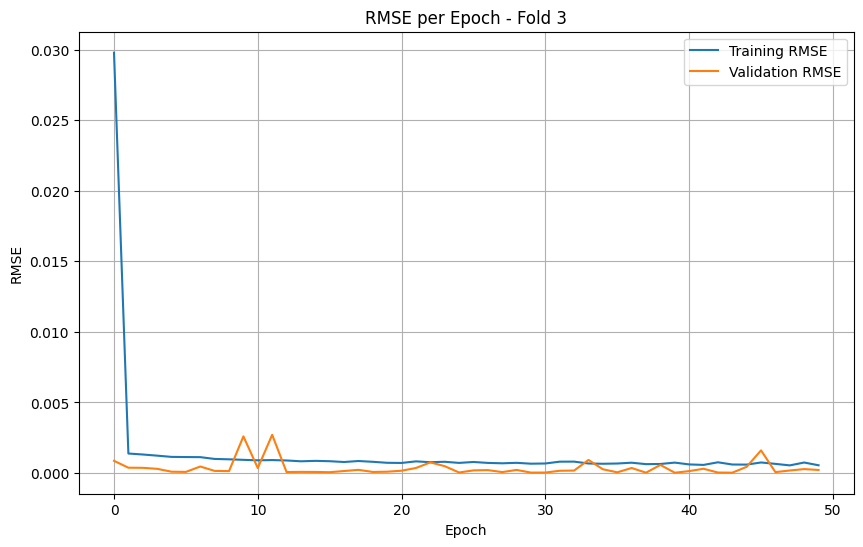

14384/14384 [==============================] - 35s 2ms/step - loss: 3.1879e-10 - root_mean_squared_error: 1.7855e-05
Signal to Noise Ratio (SNR) fold-3: tf.Tensor(82.38244120988593, shape=(), dtype=float64)
Root Mean Squared Error (RMSE) fold-3: 1.785470340109896e-05
Dimensi data pelatihan: (1841152, 1, 1)
Dimensi data pengujian: (460288, 1, 1)
Epoch 1/100
3596/3596 [==============================] - 34s 9ms/step - loss: 7.7766e-04 - root_mean_squared_error: 0.0279 - val_loss: 1.2825e-06 - val_root_mean_squared_error: 0.0011
Epoch 2/100
3596/3596 [==============================] - 31s 8ms/step - loss: 2.2248e-06 - root_mean_squared_error: 0.0015 - val_loss: 6.1641e-07 - val_root_mean_squared_error: 7.8512e-04
Epoch 3/100
3596/3596 [==============================] - 30s 8ms/step - loss: 2.0887e-06 - root_mean_squared_error: 0.0014 - val_loss: 9.7568e-07 - val_root_mean_squared_error: 9.8776e-04
Epoch 4/100
3596/3596 [==============================] - 32s 9ms/step - loss: 1.6466e-06 - ro

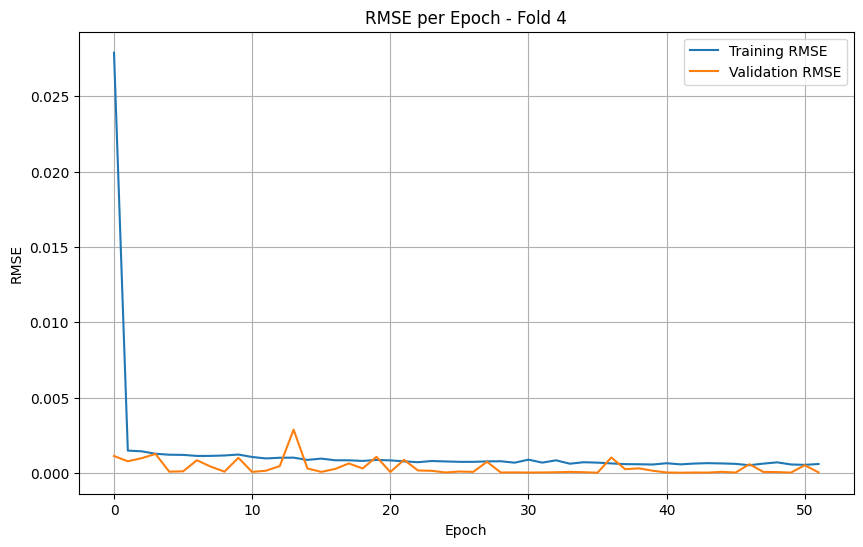

14384/14384 [==============================] - 24s 2ms/step - loss: 6.1379e-10 - root_mean_squared_error: 2.4775e-05
Signal to Noise Ratio (SNR) fold-4: tf.Tensor(79.57664086382736, shape=(), dtype=float64)
Root Mean Squared Error (RMSE) fold-4: 2.4774713892838918e-05
Dimensi data pelatihan: (1841152, 1, 1)
Dimensi data pengujian: (460288, 1, 1)
Epoch 1/100
3596/3596 [==============================] - 29s 8ms/step - loss: 9.5130e-04 - root_mean_squared_error: 0.0308 - val_loss: 4.1131e-07 - val_root_mean_squared_error: 6.4134e-04
Epoch 2/100
3596/3596 [==============================] - 39s 11ms/step - loss: 1.6273e-06 - root_mean_squared_error: 0.0013 - val_loss: 4.7936e-07 - val_root_mean_squared_error: 6.9236e-04
Epoch 3/100
3596/3596 [==============================] - 39s 11ms/step - loss: 1.2357e-06 - root_mean_squared_error: 0.0011 - val_loss: 2.2748e-05 - val_root_mean_squared_error: 0.0048
Epoch 4/100
3596/3596 [==============================] - 39s 11ms/step - loss: 1.1325e-06 

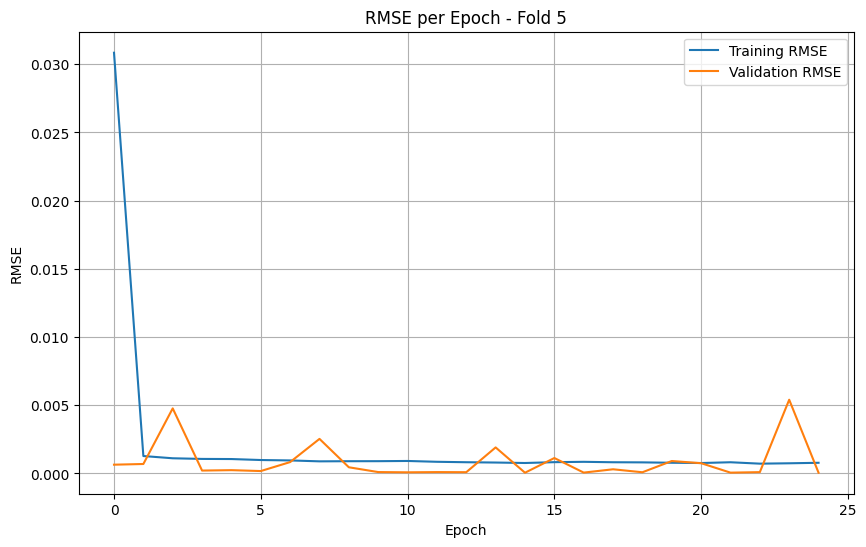

14384/14384 [==============================] - 13s 909us/step - loss: 2.7496e-09 - root_mean_squared_error: 5.2436e-05
Signal to Noise Ratio (SNR) fold-5: tf.Tensor(72.99853521331531, shape=(), dtype=float64)
Root Mean Squared Error (RMSE) fold-5: 5.243636769591831e-05


In [33]:
import matplotlib.pyplot as plt

result_snr = []
result_rmse = []
list_denoised_data = []
i = 1

for train, test in kfold.split(sign):
    train_data = sign[train]
    test_data = sign[test]

    # Pra-pemrosesan data
    train_data = train_data.reshape(train_data.shape[0], 1, 1)
    test_data = test_data.reshape(test_data.shape[0], 1, 1)

    # Mengecek dimensi data
    print("Dimensi data pelatihan:", train_data.shape)
    print("Dimensi data pengujian:", test_data.shape)

    # Membangun model autoencoder
    input_shape = train_data.shape[1:]
    model = build_autoencoder(input_shape)

    # Mengompilasi model dengan optimizer dan loss function yang sesuai
    optimizer = Adam(learning_rate=0.001)
    loss_function = MeanSquaredError()
    metrics = [RootMeanSquaredError()]
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
    
    # Menambahkan Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Melatih model menggunakan data pelatihan
    history = model.fit(train_data, train_data, batch_size=128, epochs=100, verbose=1, validation_data=(test_data, test_data), callbacks=[early_stopping])

    # Plot RMSE per epoch
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'RMSE per Epoch - Fold {i}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Menguji model menggunakan data pengujian
    denoised_data = model.predict(test_data)

    # Menghitung SNR dan RMSE
    snr = calculate_snr(test_data, denoised_data)
    rmse = model.evaluate(test_data, test_data)[1]

    # Tampilkan hasil SNR dan RMSE
    print(f'Signal to Noise Ratio (SNR) fold-{i}:', snr)
    print(f'Root Mean Squared Error (RMSE) fold-{i}:', rmse)

    result_snr.append(snr)
    result_rmse.append(rmse)
    list_denoised_data.append(denoised_data)
    i += 1

In [37]:
# Menambahkan rata-rata dari hasil SNR
average_snr = np.mean(result_snr)

# Mencetak hasil SNR dan rata-rata
k = 1
for snr_value in result_snr:
    print(f"Hasil SNR ke-{k}: {snr_value}")
    k += 1

# Mencetak rata-rata SNR
print(f"Rata-rata SNR: {average_snr}")


Hasil SNR ke-1: 77.73770774230177
Hasil SNR ke-2: 72.05165992855859
Hasil SNR ke-3: 82.38244120988593
Hasil SNR ke-4: 79.57664086382736
Hasil SNR ke-5: 72.99853521331531
Rata-rata SNR: 76.9493969915778


In [38]:
# Menambahkan rata-rata dari hasil RMSE
average_rmse = np.mean(result_rmse)

# Mencetak hasil RMSE dan rata-rata
k = 1
for rmse_value in result_rmse:
    print(f"Hasil RMSE ke-{k}: {rmse_value}")
    k += 1

# Mencetak rata-rata RMSE
print(f"Rata-rata RMSE: {average_rmse}")


Hasil RMSE ke-1: 3.025729165528901e-05
Hasil RMSE ke-2: 5.8741999964695424e-05
Hasil RMSE ke-3: 1.785470340109896e-05
Hasil RMSE ke-4: 2.4774713892838918e-05
Hasil RMSE ke-5: 5.243636769591831e-05
Rata-rata RMSE: 3.681301532196812e-05
